<br>

# NLP Exercise

## Codametrix take-home assessment

**Overview**
1. Write a python code that reads the file and stores data in an appropriate structure
    - Importing the data (Note: some light formatting done beforehand in terminal)
    - Brief EDA of the ICD DataFrame
2. ICD Code description word embedding with word2vec
    - preprocessing long descriptions
    - modeling the ICD Code description data (word2vec & TF-IDF)
    - an approach to finding similar terms
    - saving dataframe and wordvectors
3. visualizing ICD description embeddings
    - T-SNE
    - UMAP

## 1. Write a python code that reads the file and stores data in an appropriate structure.

The zip file '2021 Code Descriptions in Tabular Order – Updated 12/16/2020 (ZIP)' was downloaded from https://www.cms.gov/medicare/icd-10/2021-icd-10-cm. Next, the PDF doc 'ICD10OrderFile.pdf' was used to interpret the structure of 'icd10cm_order_2021.txt', the file to be used for this analysis.  

The following table was taken from the ICD10OrderFile.pdf:

| Position | Length | Contents                                                                                                                                        |
|:---------|:-------|:------------------------------------------------------------------------------------------------------------------------------------------------|
| 1        | 5      | Order number, right justified, zero filled.                                                                                                     |
| 6        | 1      | Blank                                                                                                                                           |
| 7        | 7      | ICD-10-CM or ICD-10-PCS code. Dots are not included.                                                                                            |
| 14       | 1      | Blank                                                                                                                                           |
| 15       | 1      | 0 if the code is a “header” –not valid for HIPAA-covered transactions.<br>1 if the code is valid for submission for HIPAA-covered transactions. |
| 16       | 1      | Blank                                                                                                                                           |
| 17       | 60     | Short Description                                                                                                                               |
| 77       | 1      | Blank                                                                                                                                           |
| 78       | To end | Long Description                                                                                                                                |


The 'icd10cm_order_2021.txt' file lacks an obvious field delimiter. To facilitate the process of importing the .txt file into the python environment as a pandas DataFrame, the above table was referenced. Character positions where the contents == 'Blank' were replaced with ';'. In terminal the UNIX streaming editor untility `sed` was used to replace character positions 6, 14, 16, and 77 with ';' using the following command:


   `$ sed 's/./;/6; s/./;/14; s/./;/16; s/./;/77' icd10cm_order_2021.txt > icd10cm_order_2021_cdelim.txt`

The output, 'icd10cm_order_2021_cdelim.txt' is now in a format that can be imported as a pandas DataFrame relatively easily:

In [1]:
import pandas as pd

In [2]:
data_file = 'icd10cm_order_2021_cdelim.txt'
# column names derived from the ICD10OrderFile.pdf documentation
col_names = ['Order_Number', 'ICD_Code', 'HIPAA_bool', 'Short_Description', 'Long_Description']
df = pd.read_csv( data_file, 
                 sep=';', 
                 header=None, 
                 index_col=False, 
                 names = col_names,
                 dtype = {'Order_Number': int, 'ICD_Code': str, 'HIPAA_bool': int,
                         'Short_Description': str, 'Long_Description': str})

In [3]:
df.head()

,Order_Number,ICD_Code,HIPAA_bool,Short_Description,Long_Description
0,1,A00,0,Cholera ...,Cholera
1,2,A000,1,"Cholera due to Vibrio cholerae 01, biovar chol...","Cholera due to Vibrio cholerae 01, biovar chol..."
2,3,A001,1,"Cholera due to Vibrio cholerae 01, biovar elto...","Cholera due to Vibrio cholerae 01, biovar eltor"
3,4,A009,1,"Cholera, unspecified ...","Cholera, unspecified"
4,5,A01,0,Typhoid and paratyphoid fevers ...,Typhoid and paratyphoid fevers


<br>

### Brief EDA of the ICD DataFrame

In [4]:
df.shape

(95358, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95358 entries, 0 to 95357
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Order_Number       95358 non-null  int64 
 1   ICD_Code           95358 non-null  object
 2   HIPAA_bool         95358 non-null  int64 
 3   Short_Description  95358 non-null  object
 4   Long_Description   95358 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB


#### Order_Number

In [6]:
# checking for duplicate Order_Number
df.Order_Number.nunique()

95358

#### ICD_Code

In [7]:
# checking for duplicate ICD_Code
df.ICD_Code.nunique()

95358

In [8]:
df.ICD_Code.apply(type).value_counts()

<class 'str'>    95358
Name: ICD_Code, dtype: int64

In [9]:
# strip the whitespace from the ICD_Code field
df['ICD_Code'] = df['ICD_Code'].str.strip()

In [10]:
# check to see if there are any empty strings after stripping whitespace
lengths = [len(c) for c in df['ICD_Code']]
from collections import Counter
Counter(lengths)

Counter({3: 1911, 4: 9965, 5: 13689, 6: 19377, 7: 50416})

In [11]:
# add a new feature to df, that labels the record with the first letter of the ICD Code
# to be used for downstream visualizations
first_letters = [c[0] for c in df['ICD_Code']]
df['Initial'] = first_letters

In [12]:
df.head()

,Order_Number,ICD_Code,HIPAA_bool,Short_Description,Long_Description,Initial
0,1,A00,0,Cholera ...,Cholera,A
1,2,A000,1,"Cholera due to Vibrio cholerae 01, biovar chol...","Cholera due to Vibrio cholerae 01, biovar chol...",A
2,3,A001,1,"Cholera due to Vibrio cholerae 01, biovar elto...","Cholera due to Vibrio cholerae 01, biovar eltor",A
3,4,A009,1,"Cholera, unspecified ...","Cholera, unspecified",A
4,5,A01,0,Typhoid and paratyphoid fevers ...,Typhoid and paratyphoid fevers,A


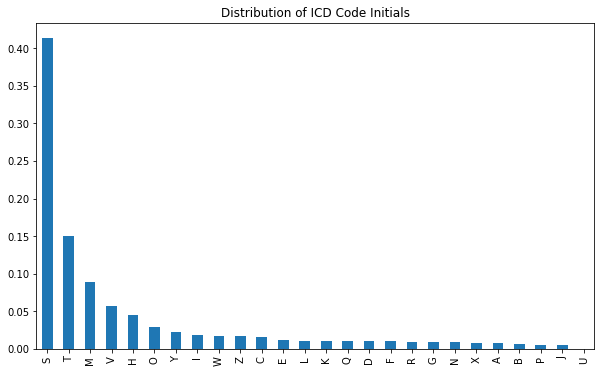

In [13]:
import matplotlib.pyplot as plt

df['Initial'].value_counts(normalize=True).plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of ICD Code Initials')
plt.show()

Roughly half of the code begin with either 'S' or 'T'.  
It will be interesting to see how these abbreviation labels distribute across a visualization of the text embeddings using t-SNE

#### HIPAA_bool

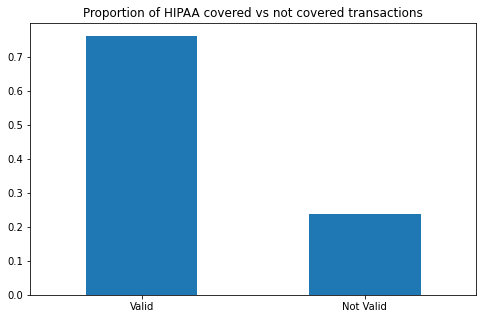

In [14]:
df['HIPAA_bool'].value_counts(normalize=True).plot(kind='bar', figsize=(8, 5))
plt.title('Proportion of HIPAA covered vs not covered transactions')
plt.xticks(ticks=[0,1], labels = ['Valid','Not Valid'], rotation=0)
plt.show()

Most are valid for submission for HIPAA-covered transactions. Unclear if this is relevant to our task  

Short and Long Descriptions will be formatted in the following section as the text is preprocessed for text embedding

## 2. ICD Code description word embedding with word2vec

Write a python code to train a word embedding model for the ICD codes using the code descriptions. You can choose any approach for this. There is no need to implement word embedding implementation from scratch. However, it is important that you train a model using the ICD descriptions. You can include other textual corpora in your training set (such as Wiki, PubMed) but the training corpus SHOULD include ICD10 descriptions.

In [15]:
# dependencies
import string
import gensim
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import numpy as np

### preprocessing long descriptions

The following code will preprocess the ICD_text_data:
* remove excess whitespace
* lowercase the text
* remove punctuation
* format as a list of lists where each nested list has word strings as elements

A few extra steps could have been taken to preprocess, but because of my lack of familiarity with ICD Code data, I held off for this WIP:
* remove numeric strings
* lemmatization to reduce the vocabulary

In [16]:
# preprocessing the long descriptions
# strip leading and lagging whitespace, lowercase text and remove punctuation
ICD_text_data = [sent.strip().lower().translate(str.maketrans('', '', string.punctuation)) for sent in df['Long_Description']]
# split into words on whitespace
ICD_text_data = [sent.split(' ') for sent in ICD_text_data]
# remove empty strings
ICD_text_data = [[string for string in lst if len(string)>=1] for lst in ICD_text_data]
# print a few examples...
ICD_text_data[0:5]

[['cholera'],
 ['cholera', 'due', 'to', 'vibrio', 'cholerae', '01', 'biovar', 'cholerae'],
 ['cholera', 'due', 'to', 'vibrio', 'cholerae', '01', 'biovar', 'eltor'],
 ['cholera', 'unspecified'],
 ['typhoid', 'and', 'paratyphoid', 'fevers']]

In [17]:
# add the preprocessed text as a new feature to the df
df['Processed_Long_Description'] = ICD_text_data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95358 entries, 0 to 95357
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Order_Number                95358 non-null  int64 
 1   ICD_Code                    95358 non-null  object
 2   HIPAA_bool                  95358 non-null  int64 
 3   Short_Description           95358 non-null  object
 4   Long_Description            95358 non-null  object
 5   Initial                     95358 non-null  object
 6   Processed_Long_Description  95358 non-null  object
dtypes: int64(2), object(5)
memory usage: 5.1+ MB


### modeling the ICD Code description data

The following code will train a Word2Vec model with the gensim library using the 'Long Description' of the ICD codes data. Additionally, a TF-IDF model will be trained on the same data; this will be used to weight the ICD Code embeddings.

In [18]:
# training the word2vec word embedding model
w2v_model = gensim.models.Word2Vec(ICD_text_data, min_count = 1, workers = 3, sg = 1)

In [19]:
# use a bag-of-words approach to build a tf-idf representation of the 
dct = Dictionary(ICD_text_data)  
ICD_text_bow = [dct.doc2bow(line) for line in ICD_text_data]  
model_tfidf = TfidfModel(ICD_text_bow)  

In [20]:
# find the tfidf weighting vector for each ICD Code. Add as a new feature to df
tfidf_weights = [ [w[1] for w in model_tfidf[ICD_text_bow[index]]] for index in range(0,len(ICD_text_bow)) ]
tfidf_weights[0:5]

[[1.0],
 [0.3331411161623295,
  0.35605147967897377,
  0.35605147967897377,
  0.7121029593579475,
  0.1157827625927998,
  0.09408596134179877,
  0.32576562648223933],
 [0.3813135874580227,
  0.4075368078252206,
  0.4075368078252206,
  0.4075368078252206,
  0.1325250424764391,
  0.10769086644710862,
  0.37287159608339926,
  0.43376002819241855],
 [0.992898940786209, 0.1189608901514454],
 [0.11321642169981003,
  0.5551970028927141,
  0.6034737328113232,
  0.5610327830378594]]

In [21]:
df['tfidf_weights'] = tfidf_weights
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95358 entries, 0 to 95357
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Order_Number                95358 non-null  int64 
 1   ICD_Code                    95358 non-null  object
 2   HIPAA_bool                  95358 non-null  int64 
 3   Short_Description           95358 non-null  object
 4   Long_Description            95358 non-null  object
 5   Initial                     95358 non-null  object
 6   Processed_Long_Description  95358 non-null  object
 7   tfidf_weights               95358 non-null  object
dtypes: int64(2), object(6)
memory usage: 5.8+ MB


### finding similar terms

an approach to provide a list of top most relevant keywords achieved via calculating the cosine similarity between the ICD code vector representation and the vector representation of different words.

* **ICD code vector representation** - calculated as a weighted average of the words in the 'Long_Description' for a given ICD Code. The weighting is determined by the TF-IDF values for the words treating each long description as a document. The weighting can be interpretted as the importance of each terms

Finding similar terms example: “M25011”

In [22]:
# calculating the weighted ICD code vector representation
case = 'A00'
processed_terms = df[df['ICD_Code']==case]['Processed_Long_Description'].item()
description_term_embeddings = w2v_model.wv[processed_terms]
weights = np.array(df[df['ICD_Code']==case]['tfidf_weights'].item())

# broadcast the weightings and take the mean of the word terms
broad_weight = np.broadcast_to(weights, description_term_embeddings.T.shape).T
weighted_ICD_vec = broad_weight * description_term_embeddings
weighted_ICD_vec = weighted_ICD_vec.mean( axis= 0 )

# return the closest word2vec terms (cosine similarity)
w2v_model.wv.most_similar(weighted_ICD_vec)[:5]

[('cholera', 1.0),
 ('babesia', 0.9800847172737122),
 ('acanthamoeba', 0.9794126152992249),
 ('cholerae', 0.9782480597496033),
 ('babesiosis', 0.9777045249938965)]

Next, find the weighted description embedding for all IDC codes and add as a feature to the df  
This will faciliate returning similar terms and be used to visualize the data in the next section

In [23]:
# functionalize the weighted description embedding 
def weighted_ICD( terms, tfidf_weights, word2vec_model):
    """
    weighted_ICD finds the weighted embedding for an ICD Code long description
    given a list of terms (list of string) of len t
    given a list of tfidf_weights (list of float) of len t
    given a word2vec_model which gives embeddings of len v
    returns a weighted mean vector of len v
    """
    # an array of embeddings for each term in terms
    terms_embeddings = word2vec_model.wv[terms]
    # tfidf_weights as an array
    tfidf_weights = np.array( tfidf_weights )
    
    # finding the weighted mean to give an embedded representation of terms
    broad_weight = np.broadcast_to(tfidf_weights, terms_embeddings.T.shape).T
    weighted_vec = broad_weight * terms_embeddings
    weighted_vec = weighted_vec.mean( axis= 0 )
    
    return weighted_vec

def related_terms( embedding, word2vec_model, num_terms ):
    """
    related_terms finds 'num_terms' similar terms for an ICD Code
    where similar is given by cosine similarity
    given embedding (array) of len v
    given a word2vec model which gives embeddings of len v
    given a num_terms (int)
    return a list of tuples of len num_terms
    each tuple holds a term (string) and cosine similarity value (float)
    """
    return word2vec_model.wv.most_similar(embedding)[:num_terms]

In [24]:
res = weighted_ICD( processed_terms, weights, w2v_model)
related_terms( res, w2v_model, 5 )

[('cholera', 1.0),
 ('babesia', 0.9800847172737122),
 ('acanthamoeba', 0.9794126152992249),
 ('cholerae', 0.9782480597496033),
 ('babesiosis', 0.9777045249938965)]

In [25]:
# add weighted ICD description embedding
weighted_embeddings = []
for index, row in df.iterrows():
    processed_terms = row['Processed_Long_Description']
    #remove duplicate terms (keep first)
    processed_terms = [i for n, i in enumerate(processed_terms) if i not in processed_terms[:n]]
    weights = row['tfidf_weights']
    try:
        res = weighted_ICD( processed_terms, weights, w2v_model)
    except:
        print(index)
    weighted_embeddings.append(res)

In [26]:
df['weighted_embeddings'] = weighted_embeddings
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95358 entries, 0 to 95357
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Order_Number                95358 non-null  int64 
 1   ICD_Code                    95358 non-null  object
 2   HIPAA_bool                  95358 non-null  int64 
 3   Short_Description           95358 non-null  object
 4   Long_Description            95358 non-null  object
 5   Initial                     95358 non-null  object
 6   Processed_Long_Description  95358 non-null  object
 7   tfidf_weights               95358 non-null  object
 8   weighted_embeddings         95358 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.5+ MB


### save results

In [27]:
# save the df; subset of columns that will be needed for returning related terms
keep_cols = ['ICD_Code', 'Initial', 'Processed_Long_Description', 'weighted_embeddings']
df_sub = df[keep_cols]
df_sub.to_parquet('ICD_Code_Embeddings.parquet')

In [28]:
# save the word2vec model, but store just the words + their trained embeddings.
word_vectors = w2v_model.wv
word_vectors.save("ICDCode_wordvectors")

<br>

## 3. visualizing ICD description embeddings

Bonus question: create T-SNE plot of ICD codes and color code based on the first letter of the code A-Z.

### T-SNE

In [29]:
from sklearn.decomposition import PCA
docs_pca = PCA(n_components=8).fit_transform(weighted_embeddings)

In [30]:
from sklearn import manifold

tsne = manifold.TSNE()
viz = tsne.fit_transform(docs_pca)

/home/bonzilla/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/bonzilla/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [31]:
# add the tsne result to df
df['tsne_x'] = viz[:,0]
df['tsne_y'] = viz[:,1]

In [32]:
# use pandas to group by first initial and find the mean of tsne_x and tsne_y
initial_agg_df = df.groupby(['Initial']).agg({'tsne_x': ['mean'], 'tsne_y': ['mean']}).reset_index()
initial_agg_df.columns = ['initial', 'x_mean', 'y_mean']
initial_agg_df.head()

,initial,x_mean,y_mean
0,A,12.079094,-2.262503
1,B,11.767957,-2.356719
2,C,-2.870045,-0.222738
3,D,3.755894,-6.631721
4,E,10.534788,5.721955


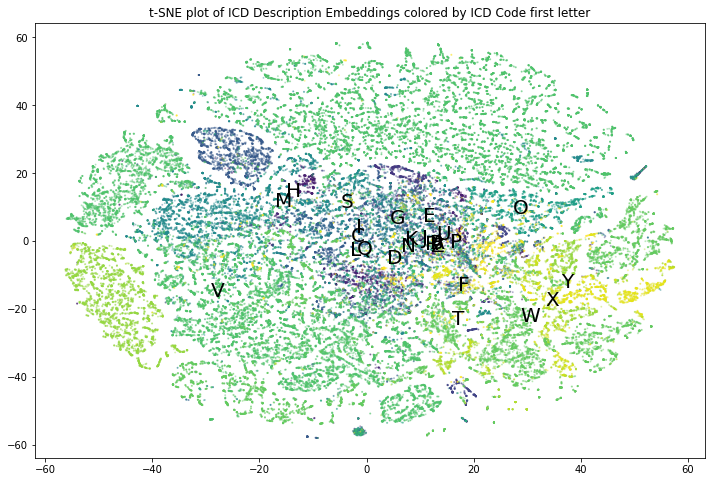

In [33]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.05) 
ax.scatter(df['tsne_x'], df['tsne_y'], marker='o', s=1,
        alpha=0.3, c=df['Initial'].astype('category').cat.codes)
for index, row in initial_agg_df.iterrows():
    plt.annotate( row['initial'], xy=( row['x_mean'], row['y_mean'] ), fontsize=20 )
plt.title( "t-SNE plot of ICD Description Embeddings colored by ICD Code first letter")
plt.show()

### UMAP 

umap borrows from topology. by considering the the data points as interrelated through a graph network, umap tries to preserve the local structure as it reduces dimensionality. 

here I will try a similar visualization after dimensionality reduction with UMAP...

In [34]:
import umap
# pip install umap-learn[plot]
import umap.plot

In [35]:
mapper = umap.UMAP(metric='cosine', n_neighbors=50, random_state=42).fit(weighted_embeddings)

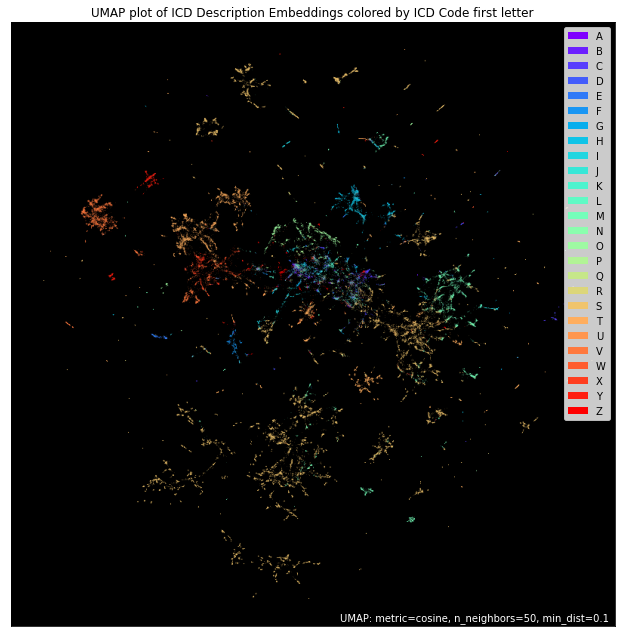

In [36]:
umap.plot.points(mapper, labels=df['Initial'], theme='fire')
plt.title('UMAP plot of ICD Description Embeddings colored by ICD Code first letter')
plt.show()

It's interesting and worth exploring: make a comparison of how well T-SNE and UMAP cluster the data in thier lower dimension spaces.